<a href="https://colab.research.google.com/github/KevinMartinez1999/Machine_Learning/blob/develop/SVM_16QAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM_16QAM Modulation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

### Generación y modulación

In [2]:
Ns = 5000
Mod = 16 #16QAM
Symbols_tx = np.random.randint(Mod, size = Ns)
df_sym_tx = pd.DataFrame(Symbols_tx)
df_sym_tx.head(10)

,0
0,0
1,2
2,15
3,8
4,14
5,1
6,8
7,3
8,10
9,15


In [3]:
mod_dict = {0:-3+3j, #0000
            1:-3+1j, #0001
            2:-3-3j, #0010
            3:-3-1j, #0011
            4:-1+3j, #0100
            5:-1+1j, #0101
            6:-1-3j, #0110
            7:-1-1j, #0111
            8:3+3j,  #1000
            9:3+1j,  #1001
            10:3-3j, #1010
            11:3-1j, #1011
            12:1+3j, #1100
            13:1+1j, #1101
            14:1-3j, #1110
            15:1-1j} #1111

In [4]:
#Modulación reemplazando símbolos por valores complejos (opción 1)
df_sym_mod = df_sym_tx.replace(mod_dict)
df_sym_mod.head(10)

,0
0,-3.0+3.0j
1,-3.0-3.0j
2,1.0-1.0j
3,3.0+3.0j
4,1.0-3.0j
5,-3.0+1.0j
6,3.0+3.0j
7,-3.0-1.0j
8,3.0-3.0j
9,1.0-1.0j


In [5]:
#Modulación reemplazando símbolos por valores complejos - mapeo (opción 2)
df_sym_mod2 = df_sym_tx.iloc[:,0].map(mod_dict)
df_sym_mod2.head(10)

0   -3.0+3.0j
1   -3.0-3.0j
2    1.0-1.0j
3    3.0+3.0j
4    1.0-3.0j
5   -3.0+1.0j
6    3.0+3.0j
7   -3.0-1.0j
8    3.0-3.0j
9    1.0-1.0j
Name: 0, dtype: complex128

### Transmision canal AWGN

In [6]:
Xr = np.real(df_sym_mod[0])
Xi = np.imag(df_sym_mod[0])

In [7]:
# Adición de ruido blanco Gaussiano (AWGN)
# Se le adiciona diferentes cantidades de ruido para ver los efectos de 
# este en la demodulación.

target_snr_db = [i for i in np.arange(0, 21, 4)]
Xr_avg_p = np.mean(Xr**2)
Xr_avg_db = 10 * np.log10(Xr_avg_p)
#print(Xr_avg_db)
noise_avg_db_r = Xr_avg_db - target_snr_db
noise_avg_p_r = 10 ** (noise_avg_db_r / 10)
mean_noise = 0
#noise_r = np.random.normal(mean_noise, np.sqrt(noise_avg_p_r), len(Xr))
noise_r= [np.random.normal(mean_noise, np.sqrt(i), len(Xr)) for i in noise_avg_p_r]
Xr_ch = Xr + noise_r

Xi_avg_p = np.mean(Xi**2)
Xi_avg_db = 10 * np.log10(Xi_avg_p)
noise_avg_db_i = Xr_avg_db - target_snr_db
noise_avg_p_i = 10 ** (noise_avg_db_i / 10)
#noise_i = np.random.normal(mean_noise, np.sqrt(noise_avg_p_i), len(Xi))
noise_i = [np.random.normal(mean_noise, np.sqrt(i), len(Xi)) for i in noise_avg_p_i]
Xi_ch = Xi + noise_i

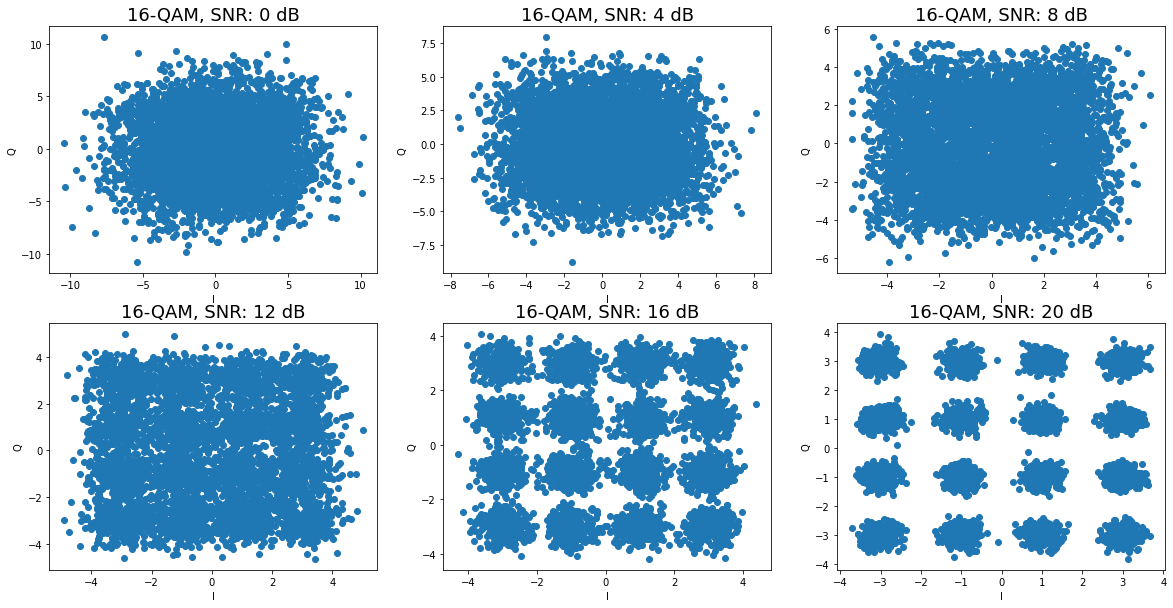

In [8]:
plt.figure(figsize=(20, 10))

for i in range(len(target_snr_db)):
  plt.subplot(2, 3, i+1)
  plt.title('16-QAM, SNR: '+str(target_snr_db[i])+' dB', fontsize = 18)
  plt.plot(Xi_ch[i], Xr_ch[i], 'o')
  plt.xlabel('I')
  plt.ylabel('Q')
plt.show()

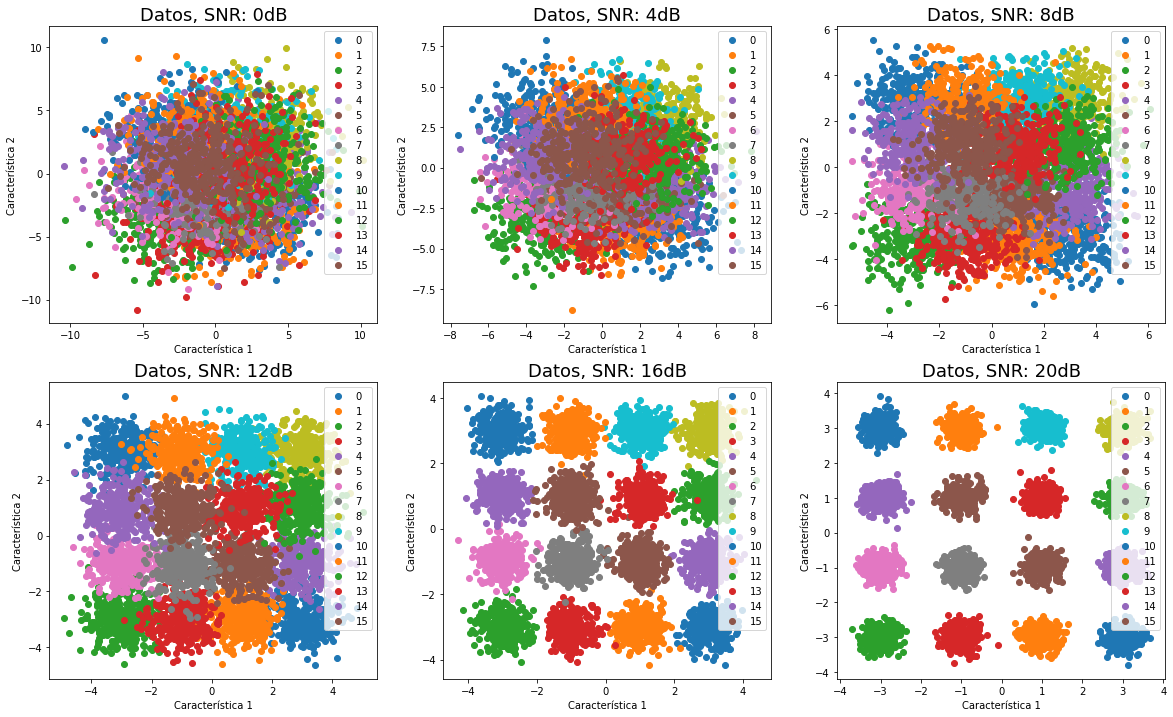

In [9]:
plt.figure(figsize=(20, 12))

for i in range(len(target_snr_db)):
  plt.subplot(2, 3, i+1)
  plt.title(f'Datos, SNR: {target_snr_db[i]}dB', fontsize = 18)
  for g in np.unique(Symbols_tx):
      ix = np.where(Symbols_tx == g)
      plt.plot(Xi_ch[i][ix], Xr_ch[i][ix], 'o', label = g)
  plt.legend(loc = 'upper right')
  plt.xlabel('Característica 1')
  plt.ylabel('Característica 2')

plt.show()

### Demodulación

In [10]:
def demapper_sym(symbols_I, symbols_Q, Ns, threshold = 2.0):
   symbol = []
   for i in range(Ns):
        if symbols_I[i] <= -threshold and symbols_Q[i] >= threshold: #-3+3j
            symbol.append(0)
        elif symbols_I[i] <= -threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #-3+1j
            symbol.append(1)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #-3-j
            symbol.append(3)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= -threshold: #-3-3j
            symbol.append(2)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= threshold: #-1+3j
            symbol.append(4)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #-1+j
            symbol.append(5)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #-1-j
            symbol.append(7)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= -threshold: #-1-3j
            symbol.append(6)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= threshold: #1+3j
            symbol.append(12)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #1+j
            symbol.append(13)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #1-j
            symbol.append(15)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= -threshold: #1-3j
            symbol.append(14)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= threshold: #3+3j
            symbol.append(8)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #3+1j
            symbol.append(9)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #3-1j
            symbol.append(11)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= -threshold: #3-3j
            symbol.append(10)
   return(symbol)

In [11]:
#sym_rx = demapper_sym(Xr_ch[0], Xi_ch[0], len(Xr_ch[0]), threshold = 2.0)
sym_rx = [demapper_sym(Xr_ch[i], Xi_ch[i], len(Xr_ch[i]), threshold = 2.0) for i in range(len(target_snr_db))]
print(f'SNR {target_snr_db[0]}dB :', sym_rx[0][0:10])
print(f'SNR {target_snr_db[3]}dB:', sym_rx[3][0:10])
print('Original:', Symbols_tx[0:10])

SNR 0dB : [7, 6, 7, 12, 15, 1, 8, 1, 14, 5]
SNR 12dB: [0, 2, 13, 12, 14, 3, 8, 3, 11, 15]
Original: [ 0  2 15  8 14  1  8  3 10 15]


In [12]:
def SymbolErrorRate(sym_rx, sym_tx):
  error = 0
  for i, rx in enumerate(sym_rx):
    if rx != sym_tx[i]:
      error += 1
  SER = error / len(sym_tx)
  return SER, error

In [13]:
def BitErrorRate(sym_rx, sym_tx):
  sym_rx_bin = ''.join([f'{sym:04b}' for sym in sym_rx])
  sym_tx_bin = ''.join([f'{sym:04b}' for sym in sym_tx])

  error = 0
  for i in range(len(sym_tx_bin)):
    if sym_rx_bin[i] != sym_tx_bin[i]:
      error += 1
  BER = error / len(sym_tx_bin)
  return BER, error

In [14]:
arr_SER = []
for i in range(len(target_snr_db)):
  SER, error = SymbolErrorRate(sym_rx[i], Symbols_tx)
  arr_SER.append(SER)
  print(f'SER {target_snr_db[i]}dB:', SER)
  print(f'Error {target_snr_db[i]}dB:', error, '\n')

SER 0dB: 0.7392
Error 0dB: 3696 

SER 4dB: 0.5808
Error 4dB: 2904 

SER 8dB: 0.3676
Error 8dB: 1838 

SER 12dB: 0.1156
Error 12dB: 578 

SER 16dB: 0.0084
Error 16dB: 42 

SER 20dB: 0.0
Error 20dB: 0 



In [15]:
arr_BER = []
for i in range(len(target_snr_db)):
  BER, error = BitErrorRate(sym_rx[i], Symbols_tx)
  arr_BER.append(BER)
  print(f'SER {target_snr_db[i]}dB:', BER)
  print(f'Error {target_snr_db[i]}dB:', error, '\n')

SER 0dB: 0.28565
Error 0dB: 5713 

SER 4dB: 0.1873
Error 4dB: 3746 

SER 8dB: 0.1025
Error 8dB: 2050 

SER 12dB: 0.02965
Error 12dB: 593 

SER 16dB: 0.0021
Error 16dB: 42 

SER 20dB: 0.0
Error 20dB: 0 



### Demodulación usando SVM

In [16]:
BER_svm = []
best = []

for i in range(len(target_snr_db)):
  X = np.transpose(np.array([Xr_ch[i], Xi_ch[i]]))
  y = Symbols_tx

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

  param_grid = {
      'C':[0.01, 0.1, 1, 10, 100, 1000],
      'gamma':[1,0.1,0.01, 0.001, 0.0001, 0.00001]
  }
  grid = GridSearchCV(SVC(), param_grid, verbose = 0)
  grid.fit(X_train, y_train)

  print(grid.best_params_)

  print(grid.best_estimator_)

  y_pred = grid.predict(X_test)
  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

  SER_test, error_SER = SymbolErrorRate(y_pred, y_test)
  print(f'SER: {SER_test}, Error sym: {error_SER}')

  BER_test, error_BER = BitErrorRate(y_pred, y_test)
  print(f'BER: {BER_test}, Error Bit: {error_BER}')

  print('\n')

  best.append(grid.best_estimator_)
  BER_svm.append(BER_test)

{'C': 1000, 'gamma': 1e-05}
SVC(C=1000, gamma=1e-05)
Accuracy: 0.264
SER: 0.736, Error sym: 1104
BER: 0.28, Error Bit: 1680


{'C': 100, 'gamma': 0.0001}
SVC(C=100, gamma=0.0001)
Accuracy: 0.4206666666666667
SER: 0.5793333333333334, Error sym: 869
BER: 0.187, Error Bit: 1122


{'C': 0.1, 'gamma': 0.1}
SVC(C=0.1, gamma=0.1)
Accuracy: 0.624
SER: 0.376, Error sym: 564
BER: 0.10483333333333333, Error Bit: 629


{'C': 10, 'gamma': 0.1}
SVC(C=10, gamma=0.1)
Accuracy: 0.88
SER: 0.12, Error sym: 180
BER: 0.031, Error Bit: 186


{'C': 100, 'gamma': 0.01}
SVC(C=100, gamma=0.01)
Accuracy: 0.996
SER: 0.004, Error sym: 6
BER: 0.001, Error Bit: 6


{'C': 0.01, 'gamma': 1}
SVC(C=0.01, gamma=1)
Accuracy: 1.0
SER: 0.0, Error sym: 0
BER: 0.0, Error Bit: 0




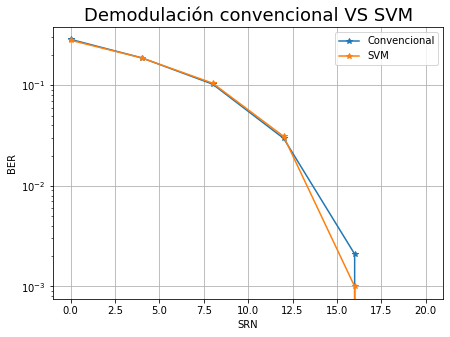

In [17]:
plt.figure(figsize=(7, 5))
plt.title('Demodulación convencional VS SVM', fontsize = 18)
plt.plot(target_snr_db, arr_BER[:], marker = '*', label = 'Convencional')
plt.plot(target_snr_db, BER_svm, marker = '*', label = 'SVM')
plt.xlabel('SRN')
plt.ylabel('BER')
plt.yscale('log')
plt.legend(loc = 'upper right')
plt.grid()
plt.show()